In [1]:

import torch
import numpy as np
import cv2
import ipdb
import scipy

from torch import nn
from PIL import Image, ImageOps
import matplotlib.pyplot as plt


from numpy import dot
from numpy.linalg import matrix_rank, inv
from numpy.random import permutation
from scipy.linalg import eigh
from scipy.linalg import norm as mnorm

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

import os
import seaborn

In [2]:
A = np.random.normal(0, 0.5,(2,2))
print('condition number:', np.linalg.cond(A))
ls1 = np.random.laplace(scale=0.3, size=16384)
ls2 = np.random.laplace(scale=1.1, size=16384)

Mixture = A@np.c_[ls1,ls2].T
# Mixture = Mixture.float()

condition number: 2.3986533890525754


In [3]:
def diagsqrts(w):
    """
    Returns direct and inverse square root normalization matrices
    """
    Di = np.diag(1. / (np.sqrt(w) + np.finfo(float).eps))
    D = np.diag(np.sqrt(w))
    return D, Di

def pca_whiten(x2d, n_comp, verbose=True):
    """ data Whitening
    *Input
    x2d : 2d data matrix of observations by variables
    n_comp: Number of components to retain
    *Output
    Xwhite : Whitened X
    white : whitening matrix (Xwhite = np.dot(white,X))
    dewhite : dewhitening matrix (X = np.dot(dewhite,Xwhite))
    """
    x2d_demean = x2d - x2d.mean(axis=1).reshape((-1, 1))
    NSUB, NVOX = x2d_demean.shape
    if NSUB > NVOX:
        cov = np.dot(x2d_demean.T, x2d_demean) / (NSUB - 1)
        w, v = eigh(cov, eigvals=(NVOX - n_comp, NVOX - 1))
        D, Di = diagsqrts(w)
        u = dot(dot(x2d_demean, v), Di)
        x_white = v.T
        white = dot(Di, u.T)
        dewhite = dot(u, D)
    else:
        cov = np.dot(x2d_demean, x2d_demean.T) / (NVOX - 1)
        w, u = eigh(cov, eigvals=(NSUB - n_comp, NSUB - 1))
        D, Di = diagsqrts(w)
        white = dot(Di, u.T)
        x_white = dot(white, x2d_demean)
        dewhite = dot(u, D)
    return (x_white, white, dewhite)

In [4]:
x_white, white, dewhite = pca_whiten(Mixture, 2)
IPT = x_white
IPT = torch.from_numpy(IPT).type(torch.float32)

(-2.612763843012291,
 21.344863167849038,
 -10.647419047838426,
 13.310207963022904)

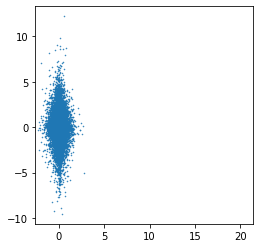

In [6]:
# the original Laplace mix
%matplotlib inline
plt.figure()
plt.plot(ls1, ls2, '.', ms=1)
plt.axis('square')

(-1.201551223517842,
 10.092000296825848,
 -6.194107065262158,
 5.0994444550815325)

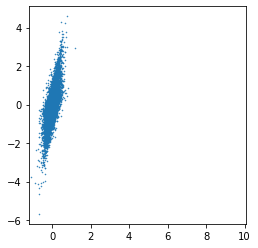

In [7]:
# the mixture of the two
%matplotlib inline
plt.plot(Mixture[0,:], Mixture[1,:], '.', ms=1)
plt.axis('square')

(-6.947683572769165, 8.132836532592773, -8.249153590202331, 6.831366515159607)

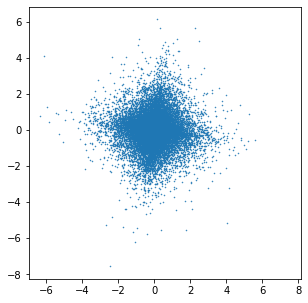

In [8]:
# the whitened source
%matplotlib inline
plt.figure(figsize=(5,5))
plt.plot(IPT[0,:], IPT[1,:], '.', ms=1)
plt.axis('square')

In [9]:
def entropyLoss(X, use_gpu=True):
    d = X.shape[0]
    n = X.shape[1]
    if use_gpu:
            eigen = torch.eye(n, n).cuda(5)
    else:
        eigen = torch.eye(n, n)
    squared_norms = (X**2).sum(0).repeat(n, 1)
    squared_norms_T = squared_norms.T
    X_T = X.T
    arg = squared_norms + squared_norms_T - 2 * torch.mm(X_T, X)
    expression = torch.sum(torch.log(torch.abs(arg)+ eigen + 1e-12))/2
    entropy = -d/(n*(n-1)) * expression
    return entropy

In [10]:
class getdata(Dataset):
    def __init__(self, mix):
        self.mix = mix

    def __getitem__(self, item):
        opt = self.mix[:, item].T
        opt.requires_grad_()
        return opt

    def __len__(self):
        return self.mix.shape[1]

In [11]:
class infomaxICA(nn.Module):

    def __init__(self, n):
        super(infomaxICA, self).__init__()
#         self.W1 = torch.nn.Linear(n, 4, bias=False)
        self.W2 = torch.nn.Linear(n, n, bias=False)
        self.init_weight()

    def weights_init(self, m, layer_type=nn.Linear):
        if isinstance(m, layer_type):
            nn.init.xavier_normal_(m.weight.data)

    def init_weight(self):
        for layer in [nn.Linear]:
            self.apply(lambda x: self.weights_init(x, layer_type=layer))

    def forward(self, input):
#         input = torch.sigmoid(self.W1(input))
        return torch.sigmoid(self.W2(input))

In [33]:
model = infomaxICA(2)

In [13]:
# IPT = torch.tensor(Mixture, dtype=torch.float32)

In [14]:

dataset = getdata(IPT)
sampler = RandomSampler(dataset)
loader = DataLoader(dataset=dataset, sampler=sampler, batch_size=64)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
#                              lr=0.1,
#                              eps=10e-4,
#                              weight_decay = 1e-3,
                            )

num_epoch = 500
scheduler = OneCycleLR(optimizer, 0.01, steps_per_epoch=len(loader), epochs=num_epoch)

# np.linalg.inv(model.W2.weight.data)

In [15]:
model = model.cuda(5)
IPT = IPT.cuda(5)

In [16]:
loss_tracker = []

<IPython.core.display.Javascript object>


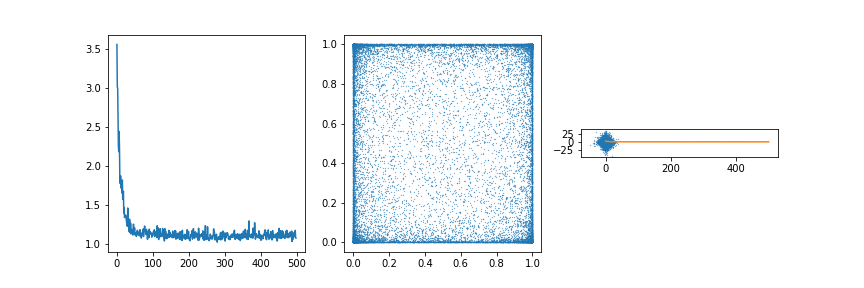

In [17]:
%matplotlib notebook
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

trace = []

for epoch in range(num_epoch):
    for _, ipt in enumerate(loader):
        model.zero_grad()
        ipt = ipt.cuda(5)
        
        opt = model.forward(ipt)
        loss = entropyLoss(opt.T)
#         loss = entropyLoss(opt.permute(1,0))
#         optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    loss = loss.cpu()
    loss_tracker.append(loss.detach().numpy())
#     if loss.detach().numpy() < 1.5: 
#         break
    if epoch % 3 == 0:
        ax.clear()
        ax.plot(loss_tracker)
        fig.canvas.draw()
        
        with torch.no_grad():
            data = model.forward(IPT.T).cpu().detach().numpy()
        ax1.clear()
        ax1.plot(data[:, 0], data[:, 1], '.', ms=0.5)
        fig.canvas.draw()
        
        data2 = (model.W2.weight.data@IPT).cpu().detach().numpy()
#         trace.append(data[300,:])
#         trace.append(data2[:,102])
        ax2.clear()
#         ax2.plot(np.array(trace)[:, 0], np.array(trace)[:, 1])
        ax2.plot(data2.T[:, 0], data2.T[:, 1], '.', ms=0.5)
        ax2.set_aspect('equal')
        fig.canvas.draw()
    
#     print(epoch, loss.detach().numpy())
    scheduler.step()

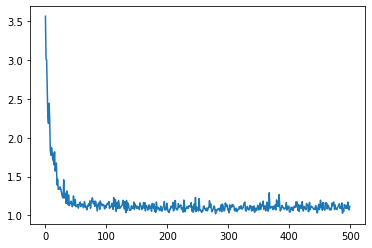

In [21]:
%matplotlib inline
plt.plot(loss_tracker)

In [22]:
model.cpu()
IPT = IPT.cpu()

In [28]:
with torch.no_grad():
    data = model.forward(IPT.T).detach().numpy() # B.detach().numpy()#

data2 = model.W2.weight.data@IPT
data2 = data2/(data2.std(axis=1).reshape((-1,1)))
print('mixture matrix:', A, sep='\n')
print('inverse of matrix in model:', np.linalg.inv(model.W2.weight.data.T), sep='\n')

mixture matrix:
[[ 0.29232625 -0.07072102]
 [ 0.19191273 -0.47363526]]
inverse of matrix in model:
[[ 0.0231799   0.15792497]
 [ 0.15712088 -0.02108736]]


(-0.05, 1.05, -0.05, 1.05)

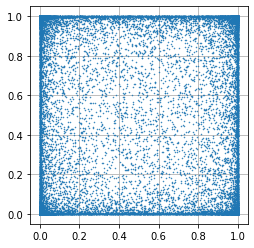

In [31]:
# plot with sigmoid
%matplotlib inline
plt.plot(data[:,0], data[:,1], '.', ms=1)
plt.grid()
plt.axis('square')

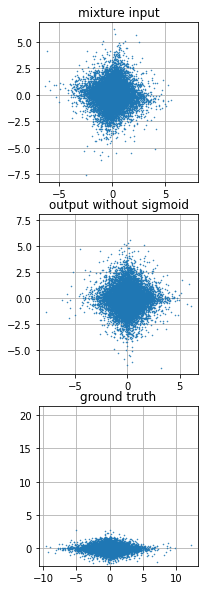

In [32]:
%matplotlib inline
plt.figure(figsize=(4,10))

plt.subplot(3,1,1)
plt.plot(IPT[0,:], IPT[1,:], '.', ms=1)
plt.title('mixture input')
plt.axis('square')
plt.grid()

# plot without sigmoid
plt.subplot(3,1,2)
plt.plot(data2.T[:,0], data2.T[:,1], '.', ms=1)
plt.title('output without sigmoid')
# plt.xlim([-5, 5])
# plt.ylim([-5, 5])
plt.axis('square')
plt.grid()

# plot of the original laplace
plt.subplot(3,1,3)
plt.plot(ls2, ls1, '.', ms=1)
plt.title('ground truth')
plt.axis('square')
plt.grid()

In [ ]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
a = torch.rand(2,200000)
b = torch.log(a/(1-a)) #inverse sigmoid


In [ ]:
#plot of random uniform
plt.plot(a[0], a[1], '.', ms=0.5)

In [ ]:
# the inverse of sigmoid
plt.plot(b[0], b[1], '.', ms=0.5)

In [ ]:
b = torch.arange(0,1,0.0001)
b = torch.log(b/(1-b))
plt.plot(b, '.', ms=0.5)

In [ ]:
c = torch.sigmoid(b)

In [ ]:
plt.plot(c[0], c[1], '.', ms=0.5)

In [ ]:
IPT = (IPT-IPT.mean(1).unsqueeze(1))/(IPT.max(1)[0]-IPT.min(1)[0]).unsqueeze(1)